# Оценка месторождений нефти
## Описание проекта

В данных пробы нефти в трёх регионах по месторождениям: измерения качества нефти и объём её запасов. Построить модель машинного обучения, чтобы определить наиболее прибыльный регион. Анализ возможной прибыли и рисков техникой *Bootstrap.*

## 1. Загрузка и подготовка данных

In [2]:
!pip install catboost

In [3]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt 

from scipy import stats as st
from math import sqrt

from catboost import Pool, CatBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. Обучение и проверка модели

In [5]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [6]:
geo_duplicated_0 = geo_data_0[geo_data_0['id'].duplicated()]
geo_duplicated_rate_0 = (geo_duplicated_0.shape[0] * 2) / geo_data_0.shape[0]

geo_duplicated_1 = geo_data_1[geo_data_1['id'].duplicated()]
geo_duplicated_rate_1 = (geo_duplicated_1.shape[0] * 2) / geo_data_1.shape[0]

geo_duplicated_2 = geo_data_1[geo_data_2['id'].duplicated()]
geo_duplicated_rate_2 = (geo_duplicated_2.shape[0] * 2) / geo_data_2.shape[0]

In [7]:
print(f'Процент скважин с одинаковыми id в первом регионе: {geo_duplicated_rate_0:0.2%}')
print(f'Процент скважин с одинаковыми id в втором регионе: {geo_duplicated_rate_1:0.2%}')
print(f'Процент скважин с одинаковыми id в третьем регионе: {geo_duplicated_rate_2:0.2%}')

Процент скважин с одинаковыми id в первом регионе: 0.02%
Процент скважин с одинаковыми id в втором регионе: 0.01%
Процент скважин с одинаковыми id в третьем регионе: 0.01%


In [8]:
sample_duplicated_id = geo_duplicated_0.head(1)['id'].values[0]
geo_data_0.query('id == @sample_duplicated_id')

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


В данных обнаружены дубликаты скважин с разными параметрами. Так как таких данных меньше 1% и определить какие значения истинные, то такие данные лучше убрать из выборки для модели. 

In [9]:
geo_duplicated_ids_0 = geo_duplicated_0['id']
geo_duplicated_ids_1 = geo_duplicated_1['id']
geo_duplicated_ids_2 = geo_duplicated_2['id']

geo_data_wo_duplicated_0 = geo_data_0.loc[geo_data_0['id'].isin(geo_duplicated_ids_0) == False]
geo_data_wo_duplicated_1 = geo_data_1.loc[geo_data_1['id'].isin(geo_duplicated_ids_1) == False]
geo_data_wo_duplicated_2 = geo_data_2.loc[geo_data_2['id'].isin(geo_duplicated_ids_2) == False]

In [10]:
features_wod_0 = geo_data_wo_duplicated_0.drop(columns=['id', 'product'], axis=1) 
target_wod_0 = geo_data_wo_duplicated_0['product']

features_wod_1 = geo_data_wo_duplicated_1.drop(columns=['id', 'product'], axis=1) 
target_wod_1 = geo_data_wo_duplicated_1['product']

features_wod_2 = geo_data_wo_duplicated_2.drop(columns=['id', 'product'], axis=1) 
target_wod_2 = geo_data_wo_duplicated_2['product']

In [11]:
X_wod_train_0, X_wod_val_0, y_wod_train_0, y_wod_val_0 = train_test_split(features_wod_0, target_wod_0, test_size=0.25, random_state=123456)
X_wod_train_1, X_wod_val_1, y_wod_train_1, y_wod_val_1 = train_test_split(features_wod_1, target_wod_1, test_size=0.25, random_state=123456)
X_wod_train_2, X_wod_val_2, y_wod_train_2, y_wod_val_2 = train_test_split(features_wod_2, target_wod_2, test_size=0.25, random_state=123456)

In [12]:
def calc_product(X_train, X_val, y_train, y_val):
    model = LinearRegression(normalize=True, n_jobs=-1)
    model.fit(X_train, y_train)

    predicted = model.predict(X_val)
    rmse_score = sqrt(mean_squared_error(y_val, predicted))
    return {'predicted': pd.Series(data=predicted, index=X_val.index), 'RMSE': rmse_score}

In [13]:
def calc_product_gradient(X_train, X_val, y_train, y_val):
    model = GradientBoostingRegressor(learning_rate=0.05, random_state=123456)
    model.fit(X_train, y_train)

    predicted = model.predict(X_val)
    rmse_score = sqrt(mean_squared_error(y_val, predicted))
    return {'predicted': pd.Series(data=predicted, index=X_val.index), 'RMSE': rmse_score}

In [14]:
result_wod_0 = calc_product(X_wod_train_0, X_wod_val_0, y_wod_train_0, y_wod_val_0)
result_wod_1 = calc_product(X_wod_train_1, X_wod_val_1, y_wod_train_1, y_wod_val_1)
result_wod_2 = calc_product(X_wod_train_2, X_wod_val_2, y_wod_train_2, y_wod_val_2)

print(f'Прогнозируемый средний запас сырья на скважину в регионе 1: {result_wod_0["predicted"].mean():.2f}, RMSE={result_wod_0["RMSE"]:.2f}')
print(f'Прогнозируемый средний запас сырья на скважину в регионе 2 {result_wod_1["predicted"].mean():.2f}, RMSE={result_wod_1["RMSE"]:.2f}')
print(f'Прогнозируемый средний запас сырья на скважину в регионе 3: {result_wod_2["predicted"].mean():.2f}, RMSE={result_wod_2["RMSE"]:.2f}')

Прогнозируемый средний запас сырья на скважину в регионе 1: 92.44, RMSE=37.53
Прогнозируемый средний запас сырья на скважину в регионе 2 68.34, RMSE=0.89
Прогнозируемый средний запас сырья на скважину в регионе 3: 94.85, RMSE=39.98


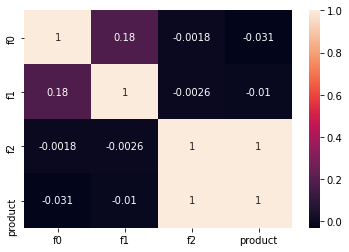

In [15]:
corrMatrix = geo_data_wo_duplicated_1.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

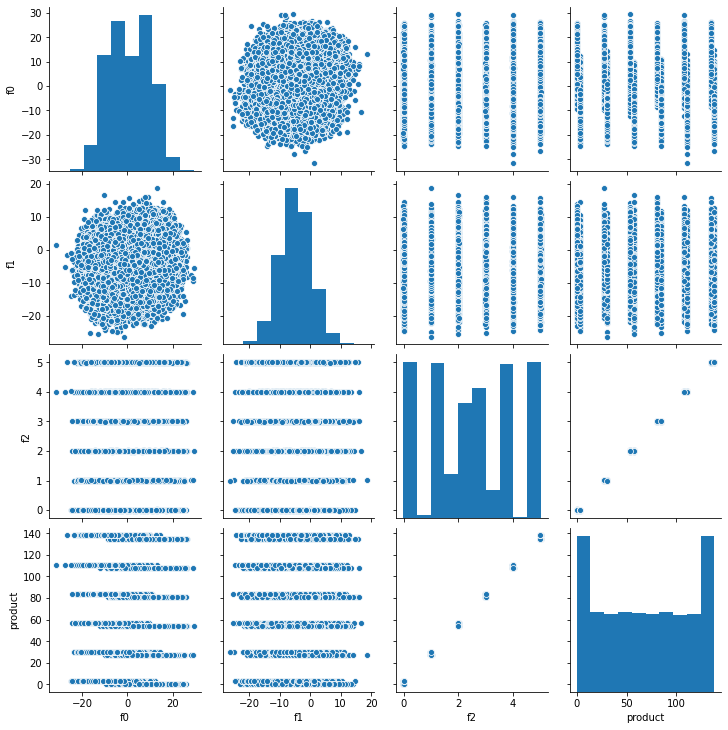

In [16]:
sn.pairplot(geo_data_wo_duplicated_1)

По **региону 2** обнаружена корреляция `f2` и целевым признаком, поэтому `RMSE` модели по региону оказалось неожиданно низким. В других регионах корреляции, влияющие на результат, между признаками не обнаружены.

## 3. Подготовка к расчёту прибыли

In [17]:
POINTS = 500
SELECTED_POINTS = 200
BUDGET = 10 ** 10
INCOME_PER_BARREL = 450 * 1000

Расчет достаточного объёма сырья для безубыточной разработки новой скважины (точка безубыточности).

In [18]:
break_even_price = int(BUDGET / (INCOME_PER_BARREL * SELECTED_POINTS))
print(break_even_price)

111


In [19]:
predicted_profit_region_0 = result_wod_0["predicted"].mean() / break_even_price
predicted_profit_region_1 = result_wod_1["predicted"].mean() / break_even_price
predicted_profit_region_2 = result_wod_2["predicted"].mean() / break_even_price

print('Сравнение достаточного объема сырья с смоделированным средним запасам скважины в регионе:')
print(f'Регион 1: {predicted_profit_region_0:.2%}')
print(f'Регион 2: {predicted_profit_region_1:.2%}')
print(f'Регион 3: {predicted_profit_region_2:.2%}')

Сравнение достаточного объема сырья с смоделированным средним запасам скважины в регионе:
Регион 1: 83.28%
Регион 2: 61.57%
Регион 3: 85.45%


Средний, предсказанный моделью, запас скважины в регионах меньше чем достаточный объем для разработки новой скважины. 

## 4. Расчёт прибыли и рисков 

In [20]:
def revenue(target, predictions, selected_count):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target.loc[predictions_sorted.index][:selected_count]
    
    result = selected.sum() * INCOME_PER_BARREL - BUDGET
    
    return result

In [21]:
def calc_bootstrap(target, predictions, all_count, selected_count):
    state = np.random.RandomState(123456)
    values = []

    for i in range(1000):
        target_subsample = target.sample(n=all_count, replace=True, random_state=state)
        predictions_subsample = predictions.loc[target_subsample.index]
        values.append(revenue(pd.Series(target_subsample), pd.Series(predictions_subsample), selected_count))

    return pd.Series(values)

In [22]:
values_0 = calc_bootstrap(y_wod_val_0, result_wod_0["predicted"], POINTS, SELECTED_POINTS)
mean_0 = values_0.mean()

#interval_0 = st.t.interval(alpha=0.95, df=len(values_0)-1, loc=mean_0, scale=values_0.sem())
lower_0 = values_0.quantile(0.025)
confidence_interval_0 = (lower_0, values_0.quantile(0.975))
risk_0 = (values_0 < 0).mean()

print('Регион 1:')
print("Средняя выручка:", mean_0)
print("2.5%-квантиль:", lower_0)
print(f"Риск убытков: {risk_0:.2%}")
print("Доверительный интервал:", confidence_interval_0)

Регион 1:
Средняя выручка: 468513008.3911709
2.5%-квантиль: -33083253.498802472
Риск убытков: 3.70%
Доверительный интервал: (-33083253.498802472, 1012636880.1009579)


In [23]:
values_1 = calc_bootstrap(y_wod_val_1, result_wod_1["predicted"], POINTS, SELECTED_POINTS)
mean_1 = values_1.mean()

# interval_1 = st.t.interval(alpha=0.95, df=len(values_1)-1, loc=mean_1, scale=values_1.sem())
lower_1 = values_1.quantile(0.025)
confidence_interval_1 = (lower_1, values_1.quantile(0.975))
risk_1 = (values_1 < 0).mean()

print('Регион 2:')
print("Средняя выручка:", mean_1)
print("2.5%-квантиль:", lower_1)
print(f"Риск убытков: {risk_1:.2%}")
print("Доверительный интервал:", confidence_interval_1)

Регион 2:
Средняя выручка: 457865757.1027862
2.5%-квантиль: 6726262.07897349
Риск убытков: 2.40%
Доверительный интервал: (6726262.07897349, 877197377.0508348)


In [24]:
values_2 = calc_bootstrap(y_wod_val_2, result_wod_2["predicted"], POINTS, SELECTED_POINTS)
mean_2 = values_2.mean()

#interval_2 = st.t.interval(alpha=0.95, df=len(values_2)-1, loc=mean_2, scale=values_2.sem())
lower_2 = values_2.quantile(0.025)
confidence_interval_2 = (lower_2, values_2.quantile(0.975))
risk_2 = (values_2 < 0).mean()

print('Регион 3:')
print("Средняя выручка:", mean_2)
print("2.5%-квантиль:", lower_2)
print(f"Риск убытков: {risk_2:.2%}")
print("Доверительный интервал:", confidence_interval_2)

Регион 3:
Средняя выручка: 399676959.1642946
2.5%-квантиль: -183596061.12714967
Риск убытков: 9.40%
Доверительный интервал: (-183596061.12714967, 968278827.6580726)


Исходя из условий задачи, наиболее подходящим можно выделить регион 2. В остальных регионах риск убытков выше 2.5%. В данных обнаружены не уникальные скважины, а так же корреляция признака `f2` в втором регионе. Это требует уточнения, для увеличения точности исследования. Так же возможно проверить другие модели регрессии. `CatBoostRegressor` ниже показал другие результаты.

In [39]:
features_0 = geo_data_0.drop(columns=['id', 'product'], axis=1) 
target_0 = geo_data_0['product']

features_1 = geo_data_1.drop(columns=['id', 'product'], axis=1) 
target_1 = geo_data_1['product']

features_2 = geo_data_2.drop(columns=['id', 'product'], axis=1) 
target_2 = geo_data_2['product']

X_train_0, X_val_0, y_train_0, y_val_0 = train_test_split(features_0, target_0, test_size=0.25, random_state=123456)
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(features_1, target_1, test_size=0.25, random_state=123456)
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(features_2, target_2, test_size=0.25, random_state=123456)

In [40]:
result_0 = calc_product(X_train_0, X_val_0, y_train_0, y_val_0)
result_1 = calc_product(X_train_1, X_val_1, y_train_1, y_val_1)
result_2 = calc_product(X_train_2, X_val_2, y_train_2, y_val_2)

print(f'Прогнозируемый средний запас сырья на скважину в регионе 1: {result_0["predicted"].mean():.2f}, RMSE={result_0["RMSE"]:.2f}')
print(f'Прогнозируемый средний запас сырья на скважину в регионе 2 {result_1["predicted"].mean():.2f}, RMSE={result_1["RMSE"]:.2f}')
print(f'Прогнозируемый средний запас сырья на скважину в регионе 3: {result_2["predicted"].mean():.2f}, RMSE={result_2["RMSE"]:.2f}')

Прогнозируемый средний запас сырья на скважину в регионе 1: 92.49, RMSE=37.80
Прогнозируемый средний запас сырья на скважину в регионе 2 69.03, RMSE=0.89
Прогнозируемый средний запас сырья на скважину в регионе 3: 94.85, RMSE=39.98


In [41]:
result_gradient_0 = calc_product_gradient(X_train_0, X_val_0, y_train_0, y_val_0)
result_gradient_1 = calc_product_gradient(X_train_1, X_val_1, y_train_1, y_val_1)
result_gradient_2 = calc_product_gradient(X_train_2, X_val_2, y_train_2, y_val_2)

print('Gradient Boosting:')
print(f'Прогнозируемый средний запас сырья на скважину в регионе 1: {result_gradient_0["predicted"].mean():.2f}, RMSE={result_gradient_0["RMSE"]:.2f}')
print(f'Прогнозируемый средний запас сырья на скважину в регионе 2 {result_gradient_1["predicted"].mean():.2f}, RMSE={result_gradient_1["RMSE"]:.2f}')
print(f'Прогнозируемый средний запас сырья на скважину в регионе 3: {result_gradient_2["predicted"].mean():.2f}, RMSE={result_gradient_2["RMSE"]:.2f}')

Gradient Boosting:
Прогнозируемый средний запас сырья на скважину в регионе 1: 92.52, RMSE=37.37
Прогнозируемый средний запас сырья на скважину в регионе 2 69.03, RMSE=0.83
Прогнозируемый средний запас сырья на скважину в регионе 3: 94.97, RMSE=37.81


In [42]:
values_0 = calc_bootstrap(y_val_0, result_0["predicted"], POINTS, SELECTED_POINTS)
mean_0 = values_0.mean()

#interval_0 = st.t.interval(alpha=0.95, df=len(values_0)-1, loc=mean_0, scale=values_0.sem())
lower_0 = values_0.quantile(0.025)
confidence_interval_0 = (lower_0, values_0.quantile(0.975))
risk_0 = (values_0 < 0).mean()

print('Регион 1:')
print("Средняя выручка:", mean_0)
print("2.5%-квантиль:", lower_0)
print(f"Риск убытков: {risk_0:.2%}")
print("Доверительный интервал:", confidence_interval_0)

Регион 1:
Средняя выручка: 514982426.41315514
2.5%-квантиль: 11215333.057254456
Риск убытков: 2.50%
Доверительный интервал: (11215333.057254456, 1054790677.9972688)


In [43]:
values_0 = calc_bootstrap(y_val_0, result_gradient_0["predicted"], POINTS, SELECTED_POINTS)
mean_0 = values_0.mean()

#interval_0 = st.t.interval(alpha=0.95, df=len(values_0)-1, loc=mean_0, scale=values_0.sem())
lower_0 = values_0.quantile(0.025)
confidence_interval_0 = (lower_0, values_0.quantile(0.975))
risk_0 = (values_0 < 0).mean()

print('Gradient Boosting:')
print('Регион 1:')
print("Средняя выручка:", mean_0)
print("2.5%-квантиль:", lower_0)
print(f"Риск убытков: {risk_0:.2%}")
print("Доверительный интервал:", confidence_interval_0)

Gradient Boosting:
Регион 1:
Средняя выручка: 565275218.2282058
2.5%-квантиль: 44381441.34385325
Риск убытков: 1.80%
Доверительный интервал: (44381441.34385325, 1094886330.6550767)


In [44]:
values_1 = calc_bootstrap(y_val_1, result_1["predicted"], POINTS, SELECTED_POINTS)
mean_1 = values_1.mean()

# interval_1 = st.t.interval(alpha=0.95, df=len(values_1)-1, loc=mean_1, scale=values_1.sem())
lower_1 = values_1.quantile(0.025)
confidence_interval_1 = (lower_1, values_1.quantile(0.975))
risk_1 = (values_1 < 0).mean()

print('Регион 2:')
print("Средняя выручка:", mean_1)
print("2.5%-квантиль:", lower_1)
print(f"Риск убытков: {risk_1:.2%}")
print("Доверительный интервал:", confidence_interval_1)

Регион 2:
Средняя выручка: 514103238.64642835
2.5%-квантиль: 80274454.78684306
Риск убытков: 0.70%
Доверительный интервал: (80274454.78684306, 915708403.7454765)


In [45]:
values_0 = calc_bootstrap(y_val_0, result_gradient_1["predicted"], POINTS, SELECTED_POINTS)
mean_0 = values_0.mean()

#interval_0 = st.t.interval(alpha=0.95, df=len(values_0)-1, loc=mean_0, scale=values_0.sem())
lower_0 = values_0.quantile(0.025)
confidence_interval_0 = (lower_0, values_0.quantile(0.975))
risk_0 = (values_0 < 0).mean()

print('Gradient Boosting:')
print('Регион 1:')
print("Средняя выручка:", mean_0)
print("2.5%-квантиль:", lower_0)
print(f"Риск убытков: {risk_0:.2%}")
print("Доверительный интервал:", confidence_interval_0)

Gradient Boosting:
Регион 1:
Средняя выручка: -1609079362.8213964
2.5%-квантиль: -2165504790.5740175
Риск убытков: 100.00%
Доверительный интервал: (-2165504790.5740175, -1033937056.4259568)


In [46]:
values_2 = calc_bootstrap(y_val_2, result_2["predicted"], POINTS, SELECTED_POINTS)
mean_2 = values_2.mean()

#interval_2 = st.t.interval(alpha=0.95, df=len(values_2)-1, loc=mean_2, scale=values_2.sem())
lower_2 = values_2.quantile(0.025)
confidence_interval_2 = (lower_2, values_2.quantile(0.975))
risk_2 = (values_2 < 0).mean()

print('Регион 3:')
print("Средняя выручка:", mean_2)
print("2.5%-квантиль:", lower_2)
print(f"Риск убытков: {risk_2:.2%}")
print("Доверительный интервал:", confidence_interval_2)

Регион 3:
Средняя выручка: 399676959.1642946
2.5%-квантиль: -183596061.12714967
Риск убытков: 9.40%
Доверительный интервал: (-183596061.12714967, 968278827.6580726)


In [47]:
values_2 = calc_bootstrap(y_val_2, result_gradient_2["predicted"], POINTS, SELECTED_POINTS)
mean_2 = values_2.mean()

#interval_2 = st.t.interval(alpha=0.95, df=len(values_2)-1, loc=mean_2, scale=values_2.sem())
lower_2 = values_2.quantile(0.025)
confidence_interval_2 = (lower_2, values_2.quantile(0.975))
risk_2 = (values_2 < 0).mean()

print('Gradient Boosting:')
print('Регион 3:')
print("Средняя выручка:", mean_2)
print("2.5%-квантиль:", lower_2)
print(f"Риск убытков: {risk_2:.2%}")
print("Доверительный интервал:", confidence_interval_2)

Gradient Boosting:
Регион 3:
Средняя выручка: 673227611.3078744
2.5%-квантиль: 92840763.3007162
Риск убытков: 1.20%
Доверительный интервал: (92840763.3007162, 1186980013.2502356)


In [48]:
result_gradient_wod_0 = calc_product_gradient(X_wod_train_0, X_wod_val_0, y_wod_train_0, y_wod_val_0)
result_gradient_wod_1 = calc_product_gradient(X_wod_train_1, X_wod_val_1, y_wod_train_1, y_wod_val_1)
result_gradient_wod_2 = calc_product_gradient(X_wod_train_2, X_wod_val_2, y_wod_train_2, y_wod_val_2)

values_0 = calc_bootstrap(y_wod_val_0, result_gradient_wod_0["predicted"], POINTS, SELECTED_POINTS)
mean_0 = values_0.mean()

#interval_0 = st.t.interval(alpha=0.95, df=len(values_0)-1, loc=mean_0, scale=values_0.sem())
lower_0 = values_0.quantile(0.025)
confidence_interval_0 = (lower_0, values_0.quantile(0.975))
risk_0 = (values_0 < 0).mean()

print('Gradient Boosting without duplicates:')
print('Регион 1:')
print("Средняя выручка:", mean_0)
print("2.5%-квантиль:", lower_0)
print(f"Риск убытков: {risk_0:.2%}")
print("Доверительный интервал:", confidence_interval_0)



Gradient Boosting without duplicates:
Регион 1:
Средняя выручка: 504110378.5395823
2.5%-квантиль: -34854545.716773555
Риск убытков: 3.10%
Доверительный интервал: (-34854545.716773555, 1027349875.1716329)


In [49]:
train_pool_0 = Pool(X_wod_train_0, y_wod_train_0)
valid_pool_0 = Pool(X_wod_val_0, y_wod_val_0)

cat_model_0 = CatBoostRegressor(iterations=100000, early_stopping_rounds=2000, learning_rate=0.05, thread_count=-1, random_state=123456)
cat_model_0.fit(train_pool_0, eval_set=valid_pool_0, verbose=100)

print(cat_model_0.best_score_)

0:	learn: 43.7604402	test: 43.6623442	best: 43.6623442 (0)	total: 65.5ms	remaining: 1h 49m 11s
100:	learn: 37.1257876	test: 36.9617996	best: 36.9617996 (100)	total: 1.36s	remaining: 22m 29s
200:	learn: 37.0511749	test: 36.9306070	best: 36.9297325 (183)	total: 2.64s	remaining: 21m 48s
300:	learn: 36.9755239	test: 36.9376137	best: 36.9297325 (183)	total: 3.91s	remaining: 21m 35s
400:	learn: 36.8993711	test: 36.9447052	best: 36.9297325 (183)	total: 5.18s	remaining: 21m 26s
500:	learn: 36.8268981	test: 36.9537802	best: 36.9297325 (183)	total: 6.47s	remaining: 21m 25s
600:	learn: 36.7577875	test: 36.9636802	best: 36.9297325 (183)	total: 7.75s	remaining: 21m 21s
700:	learn: 36.6934929	test: 36.9709448	best: 36.9297325 (183)	total: 9.03s	remaining: 21m 18s
800:	learn: 36.6336504	test: 36.9831497	best: 36.9297325 (183)	total: 10.3s	remaining: 21m 18s
900:	learn: 36.5733777	test: 36.9930931	best: 36.9297325 (183)	total: 11.6s	remaining: 21m 19s
1000:	learn: 36.5134809	test: 37.0040327	best: 36.

In [50]:
cat_predict_0 = cat_model_0.predict(X_wod_val_0)
cat_predict_0 = pd.Series(cat_predict_0, index=X_wod_val_0.index)
cat_values_0 = calc_bootstrap(y_wod_val_0, cat_predict_0, POINTS, SELECTED_POINTS)

cat_mean_0 = cat_values_0.mean()
cat_interval_0 = st.t.interval(alpha=0.95, df=len(cat_values_0)-1, loc=cat_mean_0, scale=cat_values_0.sem())
cat_lower_0 = cat_values_0.quantile(0.025)
cat_risk_0 = (cat_values_0 < 0).mean()

print('Регион 1:')
print("Средняя выручка:", cat_mean_0)
print("2.5%-квантиль:", cat_lower_0)
print(f"Риск убытков: {cat_risk_0:.2%}")
print("Доверительный интервал:", cat_interval_0)

Регион 1:
Средняя выручка: 525402667.9783285
2.5%-квантиль: 8523688.580779457
Риск убытков: 2.30%
Доверительный интервал: (508027860.3484447, 542777475.6082124)


In [51]:
train_pool_1 = Pool(X_wod_train_1, y_wod_train_1)
valid_pool_1 = Pool(X_wod_val_1, y_wod_val_1)

cat_model_1 = CatBoostRegressor(iterations=100000, early_stopping_rounds=2000, learning_rate=0.05, thread_count=-1, random_state=123456)
cat_model_1.fit(train_pool_1, eval_set=valid_pool_1, verbose=100)

print(cat_model_1.best_score_)

0:	learn: 43.7041302	test: 43.7650293	best: 43.7650293 (0)	total: 16ms	remaining: 26m 41s
100:	learn: 1.8217780	test: 1.8462330	best: 1.8462330 (100)	total: 1.33s	remaining: 22m 1s
200:	learn: 1.5502635	test: 1.6048497	best: 1.6048497 (200)	total: 2.66s	remaining: 22m
300:	learn: 1.5015659	test: 1.5820899	best: 1.5820899 (300)	total: 3.98s	remaining: 21m 57s
400:	learn: 1.4817752	test: 1.5810816	best: 1.5805787 (393)	total: 5.28s	remaining: 21m 50s
500:	learn: 1.4620907	test: 1.5834637	best: 1.5805787 (393)	total: 6.57s	remaining: 21m 44s
600:	learn: 1.4491370	test: 1.5842182	best: 1.5805787 (393)	total: 7.88s	remaining: 21m 43s
700:	learn: 1.4370393	test: 1.5872356	best: 1.5805787 (393)	total: 9.19s	remaining: 21m 42s
800:	learn: 1.4242591	test: 1.5899156	best: 1.5805787 (393)	total: 10.5s	remaining: 21m 37s
900:	learn: 1.4123994	test: 1.5910357	best: 1.5805787 (393)	total: 11.8s	remaining: 21m 33s
1000:	learn: 1.4031141	test: 1.5935278	best: 1.5805787 (393)	total: 13s	remaining: 21m 

In [52]:
cat_predict_1 = cat_model_1.predict(X_wod_val_1)
cat_predict_1 = pd.Series(cat_predict_1, index=X_wod_val_1.index)
cat_values_1 = calc_bootstrap(y_wod_val_1, cat_predict_1, POINTS, SELECTED_POINTS)

cat_mean_1 = cat_values_1.mean()
cat_interval_1 = st.t.interval(alpha=0.95, df=len(cat_values_1)-1, loc=cat_mean_1, scale=cat_values_1.sem())
cat_lower_1 = cat_values_1.quantile(0.025)
cat_risk_1 = (cat_values_1 < 0).mean()

print('Регион 2:')
print("Средняя выручка:", cat_mean_1)
print("2.5%-квантиль:", cat_lower_1)
print(f"Риск убытков: {cat_risk_1:.2%}")
print("Доверительный интервал:", cat_interval_1)

Регион 2:
Средняя выручка: 457459529.9924857
2.5%-квантиль: 6726262.07897349
Риск убытков: 2.40%
Доверительный интервал: (443673122.0940079, 471245937.8909635)


In [53]:
train_pool_2 = Pool(X_wod_train_2, y_wod_train_2)
valid_pool_2 = Pool(X_wod_val_2, y_wod_val_2)

cat_model_2 = CatBoostRegressor(iterations=100000, early_stopping_rounds=2000, learning_rate=0.05, thread_count=-1, random_state=123456)
cat_model_2.fit(train_pool_2, eval_set=valid_pool_2, verbose=100)

print(cat_model_2.best_score_)

0:	learn: 44.2561253	test: 44.0624756	best: 44.0624756 (0)	total: 15.7ms	remaining: 26m 6s
100:	learn: 37.6259663	test: 37.5600995	best: 37.5600995 (100)	total: 1.3s	remaining: 21m 24s
200:	learn: 37.5044872	test: 37.4791416	best: 37.4787553 (192)	total: 2.59s	remaining: 21m 25s
300:	learn: 37.3931791	test: 37.4346622	best: 37.4338111 (297)	total: 3.86s	remaining: 21m 18s
400:	learn: 37.2986528	test: 37.4184410	best: 37.4176164 (384)	total: 5.16s	remaining: 21m 22s
500:	learn: 37.2200126	test: 37.4112580	best: 37.4106775 (497)	total: 6.48s	remaining: 21m 27s
600:	learn: 37.1487323	test: 37.4132253	best: 37.4106775 (497)	total: 7.76s	remaining: 21m 24s
700:	learn: 37.0816342	test: 37.4172308	best: 37.4106775 (497)	total: 9.05s	remaining: 21m 22s
800:	learn: 37.0184377	test: 37.4183022	best: 37.4106775 (497)	total: 10.3s	remaining: 21m 18s
900:	learn: 36.9565321	test: 37.4227193	best: 37.4106775 (497)	total: 11.6s	remaining: 21m 17s
1000:	learn: 36.8953058	test: 37.4247352	best: 37.41067

In [54]:
cat_predict_2 = cat_model_2.predict(X_wod_val_2)
cat_predict_2 = pd.Series(cat_predict_2, index=X_wod_val_2.index)
cat_values_2 = calc_bootstrap(y_wod_val_2, cat_predict_2, POINTS, SELECTED_POINTS)

cat_mean_2 = cat_values_2.mean()
cat_interval_2 = st.t.interval(alpha=0.95, df=len(cat_values_2)-1, loc=cat_mean_2, scale=cat_values_2.sem())
cat_lower_2 = cat_values_2.quantile(0.025)
cat_risk_2 = (cat_values_2 < 0).mean()

print('Регион 3:')
print("Средняя выручка:", cat_mean_2)
print("2.5%-квантиль:", cat_lower_2)
print(f"Риск убытков: {cat_risk_2:.2%}")
print("Доверительный интервал:", cat_interval_2)

Регион 3:
Средняя выручка: 706816105.1446465
2.5%-квантиль: 144081218.39718682
Риск убытков: 0.80%
Доверительный интервал: (689347695.6083621, 724284514.680931)
